In [ ]:
#The main structure of this code (until cells that determine lane incursions) was not written by us, but there are plenty of adjustments and tweaks
#that have been made to fit our dataset and needs. The original code should be referenced in the paper, and cand be found at:
#                           https://www.kaggle.com/code/ripon107/lane-detection/notebook


In [1]:
#importation of needed packages

#Some of these packages may need to be installed to your system. For the majority of them, you can simply use the command 'pip install [package name]'
#For the albumentations package, you will want to use 'pip install -U albumentations[imgaug]'

import numpy as np 
import pandas as pd 
import os
import torch

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch import LongTensor

import re
import cv2

import albumentations as albu

import torch
import segmentation_models_pytorch as smp

from segmentation_models_pytorch.utils import base
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import Accuracy

from numpy import asarray
import matplotlib
from PIL import Image, ImageDraw, ImageFont

import statistics as sta

In [7]:
#Directory to locate the images that are a part of the dataset, and the folders are defined.
DATA_DIR = 'Test_30000_Images'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_label')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')

In [8]:
#Visualization function defined
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [77]:
#Dataset class defined
class CarlaLanesDataset(Dataset):
    
    #Just two classes of the mask. Lane markings are one class and background is the other,
    CLASSES = ['background', 'lane']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        #This lists the image names. The list is sorted and then the first entry is removed, as sometimes it contains a checkpoint file
        self.ids = sorted(os.listdir(images_dir))
        self.ids.pop(0)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        
        
        get_label_name = lambda fn: re.sub("LF", "M", fn) #comment this line after the model has been trained
        #get_label_name = lambda fn: re.sub(".png", "_label.png", fn) #uncomment this line when applying masks to real images
        self.masks_fps = [os.path.join(masks_dir, get_label_name(image_id)) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, LongTensor(mask)
        
    def __len__(self):
        return len(self.ids)

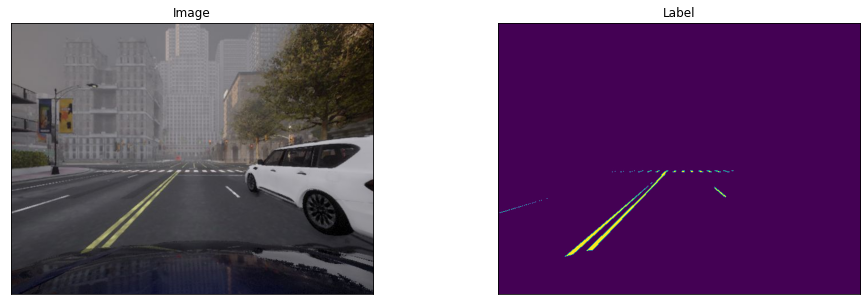

In [15]:
#Our dataset is defined
dataset = CarlaLanesDataset(x_train_dir, y_train_dir, classes=CarlaLanesDataset.CLASSES)

In [17]:
#This is the augmentation algorithm already built-in to the code
def get_training_augmentation():
    train_transform = [
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0., shift_limit=0.1, p=1, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.6,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    return None

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):   
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)


/home/exouser/.local/lib/python3.9/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/exouser/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/home/exouser/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


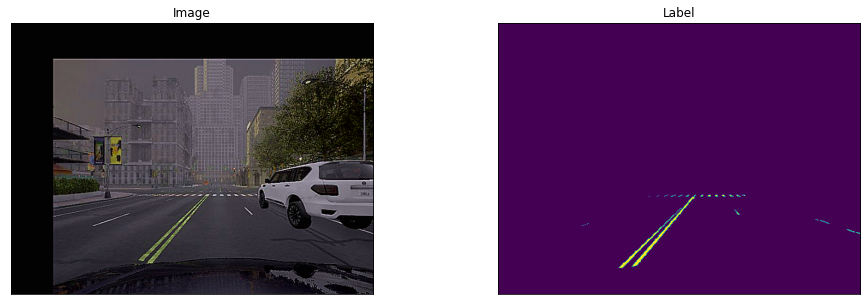

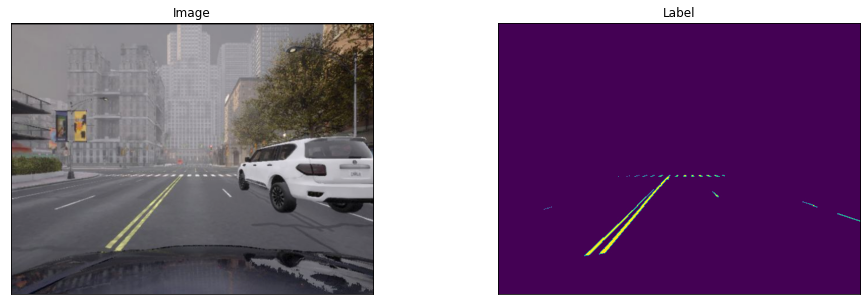

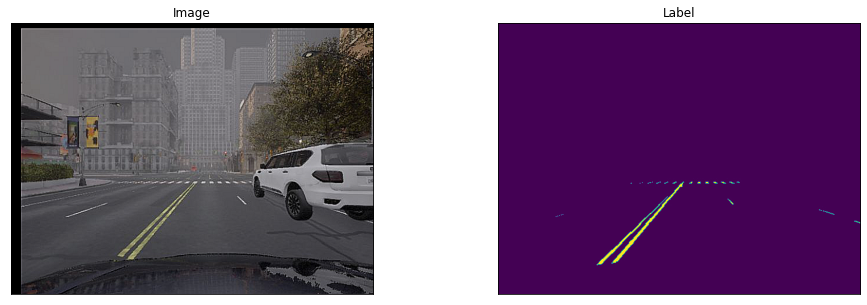

In [19]:
#augmented dataset defined
augmented_dataset = CarlaLanesDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=CarlaLanesDataset.CLASSES,
)


In [21]:
#Defining arguments to be placed into our model. A pytorch pretrained segmentation model is used, which uses U-Net at its core

loss_string = 'multi_dice_loss'
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'

# creation of model
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CarlaLanesDataset.CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [22]:
#Defining the training dataset and validation dataset

train_dataset = CarlaLanesDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

valid_dataset = CarlaLanesDataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

In [23]:
#Batch sizes defined and data loaders set up
bs_train = 8 
bs_valid = 8 
train_loader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=bs_valid, shuffle=False)

In [24]:
#Originally, this code seperated the right and left lanes in the images. Our masks do not work this way, but the 'label_left' name remains for our
#'lane' class
label_left = CarlaLanesDataset.CLASSES.index('lane')

#This list is initialized so that we are able to keep track of losses along the way
the_loss_list = []

#Loss function class defined
class MultiDiceLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.BinaryDiceLossLeft = DiceLoss()
        self.BinaryDiceLossRight = DiceLoss()
        
    def forward(self, y_pr, y_gt):
        left_gt = (y_gt == label_left)
        loss_left = self.BinaryDiceLossLeft.forward(y_pr[:,label_left,:,:] , left_gt)
        the_loss_list.append((loss_left*0.5).item())
        return (loss_left)*0.5

In [25]:
metrics = []

#loss defined using the MultiDiceLoss() class
loss = MultiDiceLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [26]:
# The epoch runners are created
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [27]:
#Model is trained and information is displayed to the user. The training losses and validation losses for each epoch are also recorded
import gc
 
best_loss = 1e10

epoch_loss_list = []
val_loss_list = []

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if best_loss > valid_logs[loss_string]:
        best_loss = valid_logs[loss_string]
        torch.save(model, './the1_model_{}.pth'.format(loss_string))
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
    epoch_loss_list.append(train_logs[loss_string])
    val_loss_list.append(valid_logs[loss_string])


Epoch: 0
valid: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s, multi_dice_loss - 0.3836]
Model saved!

Epoch: 1
valid:  88%|████████▊ | 329/375 [00:40<00:05,  7.99it/s, multi_dice_loss - 0.3815]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train:  49%|████▊     | 1639/3375 [06:17<06:31,  4.43it/s, multi_dice_loss - 0.3838]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train:  98%|█████████▊| 3309/3375 [12:23<00:16,  4.09it/s, multi_dice_loss - 0.3826]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



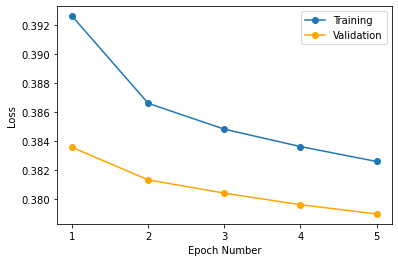

In [64]:
#Training and Validation Losses for each epoch are plotted.

plt.plot([1, 2, 3, 4, 5], epoch_loss_list, marker = 'o', label = 'Training')
plt.plot([1,2,3,4,5], val_loss_list, color='orange', marker = 'o', label = 'Validation')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.xticks([1,2,3,4,5])
plt.legend()
plt.savefig('New Highway Images2/smp_epochloss.png', bbox_inches='tight', dpi=200)

In [69]:
#The list of batch losses is separated into losses corresponding to training and losses corresponding to validation

trainlist = []
vallist = []
xtrainlist = []
xvallist = []
for i in range(5):
    for j in range(3750):
        if j > 3374:
            vallist.append(the_loss_list[i*3750 + j])
            xvallist.append(3750*i + j + 1)
        else:
            trainlist.append(the_loss_list[i*3750 + j])
            xtrainlist.append(3750*i + j + 1)
    

21749


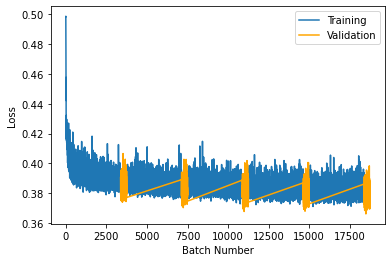

In [76]:
#The losses for each batch are plotted

plt.plot(xtrainlist, trainlist, label = 'Training')
plt.plot(xvallist, vallist, color= 'orange', label = 'Validation')
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.legend()
plt.savefig('New Highway Images2/smp_loss.png', bbox_inches='tight', dpi=200)

In [37]:
#The best saved model is loaded
best_model = torch.load('./the1_model_multi_dice_loss.pth')

In [38]:
#Testing of the best model

test_best_model = True
if test_best_model:
    # test dataset created
    test_dataset = CarlaLanesDataset(
        x_valid_dir, 
        y_valid_dir, 
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CarlaLanesDataset.CLASSES,
    )

    test_dataloader = DataLoader(test_dataset)

    # model evaluated on the set
    test_epoch = smp.utils.train.ValidEpoch(
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )

    logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 2999/2999 [01:17<00:00, 38.79it/s, multi_dice_loss - 0.3788]


In [97]:
#Accuracy function defined. This will be used for determining accuracy of predicted masks individually and also used to compare accuracy of images
#under different weather conditions
def calculate_accuracy(predictions, gt, threshold):
    
    gt = gt.numpy()
   
    # Calculate the absolute difference between predictions and ground truth
    diff = np.abs(predictions - gt)
   
    # Count the number of pixels that are close together
    close_pixels = np.count_nonzero(diff <= threshold)
   
    # Calculate the accuracy percentage
    accuracy = (close_pixels / predictions.size) * 100
   
    return accuracy

98.11263020833333


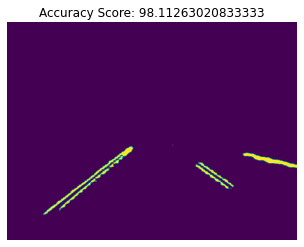

In [101]:
#This cell takes a single image from the dataset and compares the predicted mask to the ground truth mask to determine accuracy
x_train_dir = 'Test_30000_Images/train'
y_train_dir = 'Test_30000_Images/train_label'
x_valid_dir = 'Test_30000_Images/val'
y_valid_dir = 'Test_30000_Images/val_label'

the_dataset_vis = CarlaLanesDataset(
    x_train_dir, y_train_dir, 
    classes=CarlaLanesDataset.CLASSES,
    preprocessing=get_preprocessing(preprocessing_fn)
)

the_val_dataset_vis = CarlaLanesDataset(
    x_valid_dir, y_valid_dir, 
    classes=CarlaLanesDataset.CLASSES,
    preprocessing=get_preprocessing(preprocessing_fn)
)

image_vis = the_dataset_vis[460][0].astype('uint8')
image, gt_mask = the_dataset_vis[460]
#image_vis = the_val_dataset_vis[25][0].astype('uint8') #uncomment if wanting to retrieve image from validation set
#image, gt_mask = the_val_dataset_vis[25] #uncomment if wanting to retrieve image from validation set

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask_left = best_model.predict(x_tensor)[0,1,:,:] 
pr_mask_left = (pr_mask_left.cpu().numpy())

plt.axis('off')
plt.imshow(pr_mask_left)
plt.title('Accuracy Score: ' + str(calculate_accuracy(pr_mask_left, gt_mask, 0.01)))
#plt.savefig('New Highway Images2/1400.png', bbox_inches='tight', dpi=200) #Image can be saved if desired

print(calculate_accuracy(pr_mask_left, gt_mask, 0.01))

In [ ]:
#Real driving images taken, predicted masks are placed on, and then an image is outputted overlaying the mask onto the image
real_world = os.listdir("New Highway Images/Original Images")
real_world = sorted(real_world)
real_world.pop(0)

DATA_DIR2 = "New Highway Images"
x_test_dir = os.path.join(DATA_DIR2, 'Original Images')
y_test_dir = os.path.join(DATA_DIR2, 'Fake Masks')

real_dataset_vis = CarlaLanesDataset(
    x_test_dir, y_test_dir, 
    classes=CarlaLanesDataset.CLASSES,
    preprocessing=get_preprocessing(preprocessing_fn)
)

for i in range(len(real_world)):
    image = real_dataset_vis[i][0]

    img = Image.open(os.path.join(x_test_dir, real_world[i]))

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask_left = best_model.predict(x_tensor)[0,1,:,:] 
    pr_mask_left = (pr_mask_left.cpu().numpy())


    c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
    c_blue= matplotlib.colors.colorConverter.to_rgba('blue',alpha = 1)
    cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_blue],512)
    
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(pr_mask_left, cmap=cmap_rb, alpha=1)
    plt.savefig('New Highway Images2/Masked Images/frame' +str(i) + '.png', bbox_inches='tight', dpi=200)


In [43]:
#Lane position list initialized
positionList = []

for i in range(57,175):
    image = real_dataset_vis[i][0]

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask_left = best_model.predict(x_tensor)[0,1,:,:] 
    pr_mask_left = (pr_mask_left.cpu().numpy())
    
    the_array = (np.rint(pr_mask_left))[431:479] #predicted mask turned into a binary array and then only the lowest tenth of the image is used
    array_count = (the_array == 1).sum() #pixels equalling 1 are added up
    
    #If there are no pixels equaling 1, the image name is displayed to the user and the lane position value is simply assigned as zero
    if array_count == 0:
        print(real_world[i]) 
        positionList.append(0)
        
    #If some pixels present, the centroid of the mask pixels is calculated and added to the initialized position list
    else:
        y_pos, x_pos = np.argwhere(the_array==1).sum(0)/array_count
        positionList.append(x_pos)


vlcsnap-2023-05-02-00h35m00s631.png
vlcsnap-2023-05-02-00h35m02s003.png
vlcsnap-2023-05-02-00h35m03s501.png
vlcsnap-2023-05-02-00h35m04s792.png
vlcsnap-2023-05-02-00h35m31s084.png
vlcsnap-2023-05-02-00h35m42s791.png
vlcsnap-2023-05-02-00h35m43s289.png
vlcsnap-2023-05-02-00h35m43s833.png
vlcsnap-2023-05-02-00h35m57s414.png
vlcsnap-2023-05-02-00h35m57s798.png
vlcsnap-2023-05-02-00h35m58s167.png
vlcsnap-2023-05-02-00h35m58s579.png
vlcsnap-2023-05-02-00h35m59s248.png
vlcsnap-2023-05-02-00h36m37s422.png
vlcsnap-2023-05-02-00h36m37s875.png
vlcsnap-2023-05-02-00h36m55s205.png
[328.4884318766067, 328.50237933378656, 369.25958702064895, 615.5902777777778, 597.0686868686869, 335.48097412480973, 311.2447741065408, 347.37586471944655, 599.7354497354497, 322.8892551087673, 449.811320754717, 0, 0, 0, 0, 448.29583333333335, 442.944347826087, 488.46835443037975, 583.2825, 597.3576051779935, 582.1570247933885, 519.2893674293405, 15.167272727272728, 11.053333333333333, 393.8475609756098, 451.06060606060

In [44]:
#Zero values are filtered out of the data so that the data is not skewed
filtered_List = []
for item in positionList:
    if item != 0:
        filtered_List.append(item)

In [45]:
#Median and inter-quartile range are calculated from the filtered list

med = stat.median(filtered_List)
q3, q1 = np.percentile(filtered_List, [75 ,25])
iqr = q3 - q1

392.85663823532457
132.3064696848569


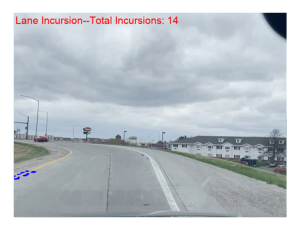

In [47]:
#The lane incursion test. If a center location is outside of the median value ± 1.5*IQR, it is marked as a lane incursion and placed onto the
#corresponding image
is_incursion = False
inc_counter = 0

for i in range(57,175):

    img = Image.open(os.path.join("New Highway Images2/Masked Images", ("frame" + str(i) + ".png")))

    if abs(positionList[i-57]-med) > (1.5*iqr):
        if is_incursion == False:
            inc_counter = inc_counter + 1
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font='arial.ttf', size=30)
        draw.text((25,25), "Lane Incursion--Total Incursions: "+ str(inc_counter), fill=(255,0,0), font=font)
        is_incursion = True
    else:
        is_incursion = False

    plt.axis('off')
    plt.imshow(img)
    plt.savefig('New Highway Images2/Incursion Images/frame' +str(i) + '.png', bbox_inches='tight', dpi=200)

